In [3]:
# Importando as libs que vamos utilizar
import pandas as pd
import numpy as np
import mglearn
import matplotlib.pyplot as plt

Na primeira parte desse capítulo, revisamos o k-NN e as autoras apresentaram algoritmos lineares de regressão e classificação, como Linear Regression, Lasso Regression, Ridge Regression, Logistic Regression e Linear Support Vector Machines. 
<br> 

Além disso, foram introduzidos algoritmos mais simples como os classificadores Naive Bayers (GaussianNB, BernoulliNB e MultiomialNB) mas também outros complexos como Decision Trees e seus Ensembles, como modelos de Random Forest e XGBoost. Discussões sobre implementação, parametrização, forças e fraquezas de cada um dos algoritmos são feitas na última parte.
<br>

Agora, na segunda parte do 2º capítulo, o livro tratará de algoritmos de **Support Vector Machines** e **Neural Networks**. Além disso, também estudaremos estimativas de incerteza em relação a classificadores:
* Funcões de Decisão;
* Prever Probabilidades;
* Incerteza em Classificadores Multiclasse.

# Supervised Learning Algorithms

## Kernelized Support Vector Machines

O primeiro algoritmo que estudaremos nessa 2ª parte é o kernelized support vector machines. 
<br>
Já vimos o uso de SVMs lineares para classificação em outro notebook. O SVM kernelizado (que também é chamado somente de SVM) é uma extensão do primeiro algoritmo que permite modelos mais complexos, não apenas aqueles que são definidos por hiperplanos.

Os SVMs funcionam tanto para classificação quanto para regressão! No entanto, aqui nesse notebook, iremos cobrir apenas o caso de classifcação. 

### Modelos lineares e features não lineares

C:\Users\bueni\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=FutureWarning)


Text(0, 0.5, 'Feature 1')

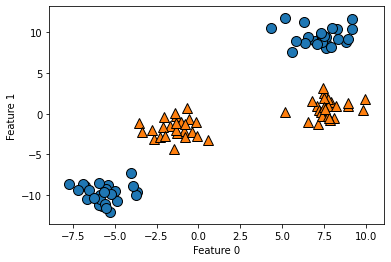

In [4]:
X, y = mglearn.datasets.make_blobs(centers = 4, random_state = 8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Como já vimos anteriormente, modelos lineares são bem limitantes em espaços de poucas dimensões, atendo-se a linhas (2D) e planos (3D). Para fazer modelos lineares mais flexíveis, podemos adicionar **novas features**, usando interações ou funções polinomiais das colunas já existentes.

No dataset acima, um modelo linear não faria um bom trabalho. 

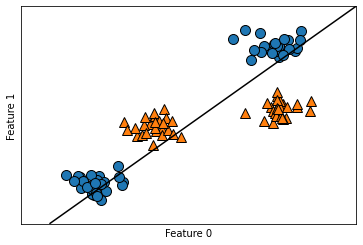

In [5]:
from sklearn.svm import LinearSVC

linear_svm = LinearSVC(max_iter = 10000).fit(X, y)
mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

plt.xlabel("Feature 0");
plt.ylabel("Feature 1");

Agora, vamos expandir o set de features, adicionando também uma coluna com a feature1². Ao invés de um plano de 2 features, usaremos um plot 3D com a terceira feature.

Text(0.5, 0, 'feature1 ** 2')

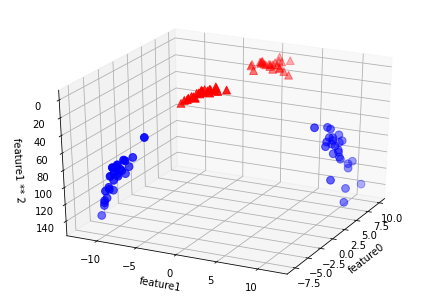

In [6]:
# adicionando a nova feature
X_new = np.hstack([X, X[:, 1:] ** 2])

#criando a figura
from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()

# visualização em 3D
ax = Axes3D(figure, elev=-152, azim=-26)
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
 cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
 cmap=mglearn.cm2, s=60)
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

Nessa nova representação dos dados, com 3 dimensões, podemos separar as duas classes utilizando um modelo linear.

C:\Users\bueni\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Text(0.5, 0, 'feature0 ** 2')

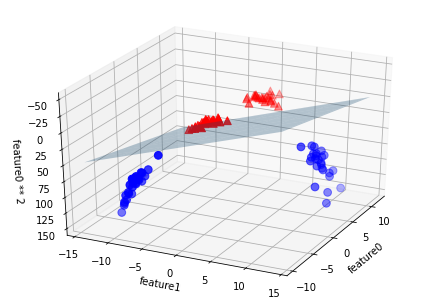

In [7]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# plotando o limite de decisão
figure = plt.figure()
ax = Axes3D(figure, elev=-150, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)
XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
 cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
 cmap=mglearn.cm2, s=60)
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature0 ** 2")

Com a adição da nova feature, o modelo SVM linear não é mais linear. Ao invés de uma linha, agora fica parecendo uma elipse quando plotado em 2D.

Text(0, 0.5, 'Feature 1')

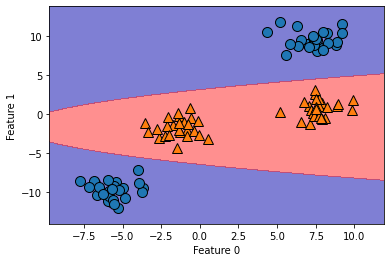

In [8]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
 cmap=mglearn.cm2, alpha=0.5)

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

### O truque da kernelização

O exemplo acima prova que adicionar features não lineares aos dados pode fazer modelos lineares muito mais fortes. O problema é que nem sempre sabemos que features adicionar e adicionar MUITAS features pode tornar a computação muito pesada.
<br>
Por sorte, tem um truque matemático que funciona calculando **diretamente a distancia entre data points e uma representação da feature expandida**, sem precisar calcular realmente a feature. Isso torna o modelo muito menos pesado computacionalmente e retorna a mesma complexidade do modelo caso tivesse tido suas features expandidas!
<br>

Existem 2 formas de mapear os dados em um espaço dimensional maior:
* Kernel polinomial:
    * Computa todos os possíveis polinômios das features originais até um certo grau (i.e. feature1² * feature 2³); 
* Kernel gaussiano (RBF):
    * Corresponde a uma dimensão infinta e é um pouco mais complexo de explicar. Uma forma de resumir é que o RBF calcula TODOS os graus, mas a importância de cada feature diminui quanto mais o grau aumenta. 

### Entendendo SVMs

Durante o treinamento, o SVM aprende o quão importante é cada um dos elementos do set de treino pra representar o limite de decisão de cada uma das classes. Normalmente, apenas um subset do set de treino importa pra definir o limite de decisão e são eles que são chamados **support vectors**. 
<br>

Para fazer uma previsão, a distância para cada um dos support vectors é calculada e a classificação é feita de acordo com as distâncias e as importâncias dos vetores. Podemos verificar esses valores utilizando o atributo `dual_coef_` do modelo.

[[-10.          -6.25178295  -3.73381586  10.           9.98559881]]


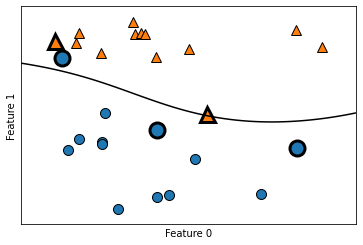

In [9]:
from sklearn.svm import SVC
X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

sv = svm.support_vectors_

sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

print(svm.dual_coef_)

No plot acima, os **support vectors** são pontos maiores e o limite de decisão é a linha preta.

### Ajustando os hiperparâmetros do SVM

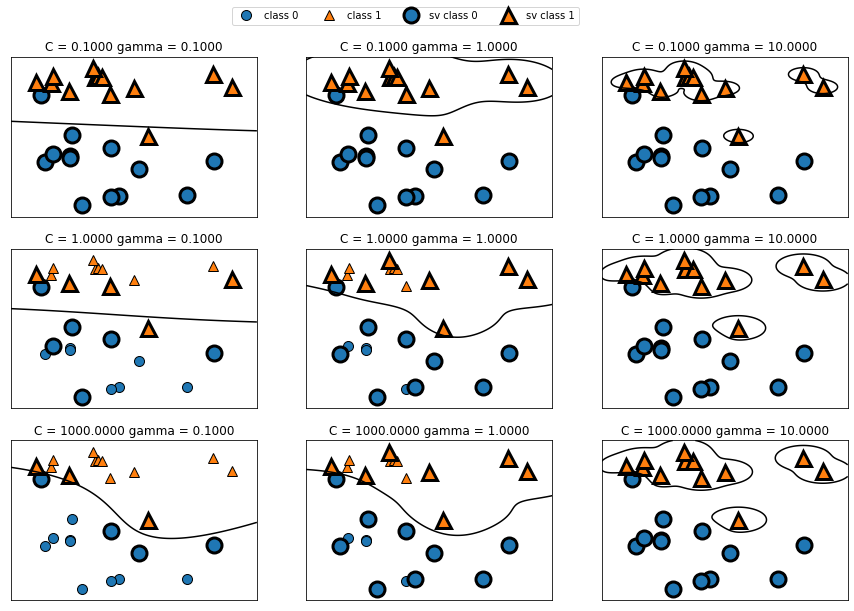

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"],
ncol=4, loc=(.9, 1.2))
axes;

Como no algoritmo de Logistic Regression, o parâmetro `C` serve para regularizar o modelo e funciona da mesma forma: **quanto maior o valor, menos a regularização.** Já o parâmetro `gamma` define o **quão perto é perto** para definir os support vectors.
<br>

Agora, vamos aplicar o SVM com kernel RBF (gaussiano) no dataset de câncer de mama, usado na primeira parte desse capítulo. Por padrão, C = 1 e gamma = 1/n_features.

In [11]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print(f"Accuracy on training set: {svc.score(X_train, y_train)}")
print(f"Accuracy on test set: {svc.score(X_test, y_test)}")

Accuracy on training set: 0.903755868544601
Accuracy on test set: 0.9370629370629371


Obtivemos um resultado excelente de primeira, mas isso não é tão comum. Os modelos de SVM são bem sensíveis a mudanças de parâmetros e ao escalonamento dos dados, necessitando que as features variem em uma escala similar.

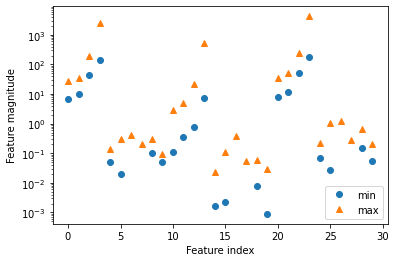

In [12]:
plt.plot(X_train.min(axis=0), 'o', label="min")
plt.plot(X_train.max(axis=0), '^', label="max")
plt.legend(loc=4)
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")
plt.yscale("log")

### Pré-processamento dos dados para SVMs

Como dito antes, deve-se reescalonar cada feature para que todas estejam no mesma escala. Um método comum usado para SVMs é reescalar os dados de forma que **todas as variáveis estejam entre 0 e 1**. 
<br>

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(cancer.data)
scaled_cancer_data = scaler.transform(cancer.data)

In [19]:
# Rodando o modelo novamente
X_train, X_test, y_train, y_test = train_test_split(scaled_cancer_data, cancer.target, random_state=0)

svc = SVC().fit(X_train, y_train)

print(f"Accuracy on training set: {svc.score(X_train, y_train)}")
print(f"Accuracy on test set: {svc.score(X_test, y_test)}")

Accuracy on training set: 0.9835680751173709
Accuracy on test set: 0.972027972027972


Após o escalonamento, os resultados do modelo foram bem melhores. Agora, podemos tentar mexer em alguns dos hiperparâmetros. Aumentar o valor de C permite modelos mais complexos que podem resultar num aumento de perfomance. 

In [29]:
svc = SVC(C = 36).fit(X_train, y_train)

print(f"Accuracy on training set: {svc.score(X_train, y_train)}")
print(f"Accuracy on test set: {svc.score(X_test, y_test)}")

Accuracy on training set: 0.9929577464788732
Accuracy on test set: 0.986013986013986


### Resumo SVM

* Kernelized SVMs são modelos poderosos que perfomam bem em uma variedade de datasets, permitindo modelos complexos mesmo que o dataset possua poucas features. Ainda assim, pode ser pesado computacionalmente caso seja utilizado em datasets muito grandes.

* Precisa de um pré-processamento dos dados cuidadoso e ajuste dos hiperparâmetros. Além disso, também é um modelo de baixa explicabilidade e interpretabilidade.

* Os parâmetros mais importantes são o de regularização (C), a escolha do kernel (RBF, Polinomial) e algum parâmetro especifico para o kernel escolhido (como o gamma). Como ambos C e gamma controlam a complexidade do modelo, ambos devem ser ajustados juntos.

## Neural Networks (Deep Learning)

Normalmente, algoritmos de deep learning são feitos sob medida para o seu uso específico. Por causa disso, nesse capítulo o livro só vai discutir sobre métodos relativamente simples como o *multilayer perceptrons* para classificação e regresssão. 

<br>
MLPs (que são conhecidos como neural networks) podem ser entendidos como generalizações de modelos lineares que perfomam múltiplos estágios de processamento para tomar uma decisão. Um modelo linear basicamente é uma soma ponderada de features:

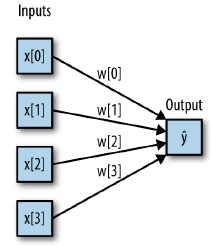

<br>
Em um modelo MLP, os dados de treino passam por um (ou mais) *hidden layer* quase como uma pré-processamento que são combinados em uma soma ponderada novamente para retornar o resultado:

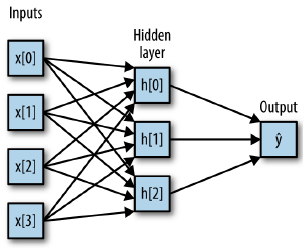

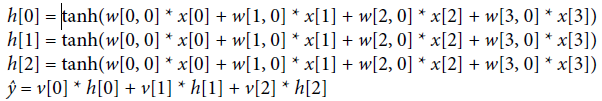
<br>
Depois do processamento realizando no *hidden layer*, os resultados são aplicados em uma função (geralmente o tanh() ou [relu](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)). O resultado é computado em uma soma ponderada e retorna o resultado final. 
<br>
O número de hidden layers é um dos parâmetros que devem ser ajustados e podem ir de poucos para datasets pequenos até milhares para dados mais complexos.

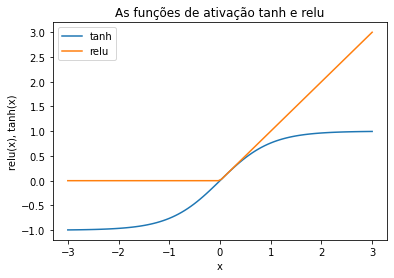

In [36]:
fig, ax = plt.subplots()
line = np.linspace(-3, 3, 100)
ax.plot(line, np.tanh(line), label="tanh")
ax.plot(line, np.maximum(line, 0), label="relu")
plt.legend(loc="best")
ax.set(xlabel = "x", 
      ylabel = "relu(x), tanh(x)",
      title = "As funções de ativação tanh e relu");

### Ajustando parâmetros de neural networks

Vamos aplicar o MLP em um dataset gerado pelo scikit-learn e tentar entender melhor os seus parâmetros.

Text(0, 0.5, 'Feature 1')

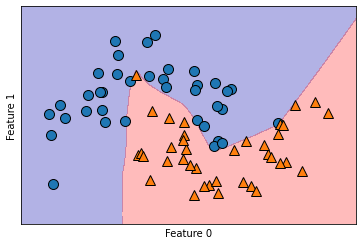

In [40]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
random_state=42)

mlp = MLPClassifier(solver='lbfgs', random_state=0).fit(X_train, y_train)

mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

A rede neural aprendeu um limite de decisão não linear mas relativamente suave. Como otimizador do gradiente descendente para selecionar os coeficientes, usamos o [algoritmo lbfgs](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm). Por padrão, o MLP usa 100 hidden nodes, o que é muito para esse dataset de apenas 100 elementos. Diminuindo esse número, reduzimos a complexidade do modelo e ainda obtemos um resultado bom.

Text(0, 0.5, 'Feature 1')

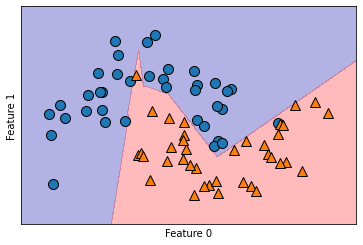

In [42]:
mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes = [10], max_iter = 1000).fit(X_train, y_train)

mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Com apenas 10 hidden nodes, o limite de decisão é mais reto. Uma vez que a função padrão de ativação é a relu e utilizando apenas um hidden layer, o limite de decisão é formado por 10 linhas retas.
<br>
Abaixo, exemplos de um modelo utilizando relu e 2 hidden layers e outro usando tanh() como função de ativação:

Text(0, 0.5, 'Feature 1')

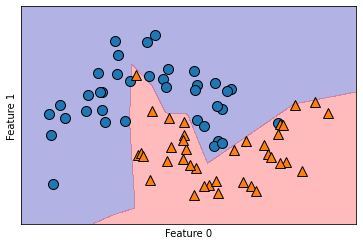

In [43]:
mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[10, 10],  max_iter = 1000)
mlp.fit(X_train, y_train)

mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0, 0.5, 'Feature 1')

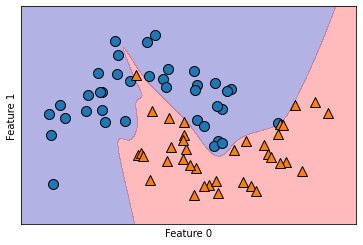

In [46]:
mlp = MLPClassifier(solver='lbfgs', activation='tanh', random_state=0, hidden_layer_sizes=[10, 10],  max_iter = 1000)
mlp.fit(X_train, y_train)

mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Além desses parâmetros, dá pra controlar a complexidade usando uma penalização `l2` pra diminuir os coeficientes pra próximo de 0, como é feito em classificadores lineares. Em neural networks, esse parâmetro é chamado de alpha e por padrão, é definido em um valor bem baixo (pouca regularização).

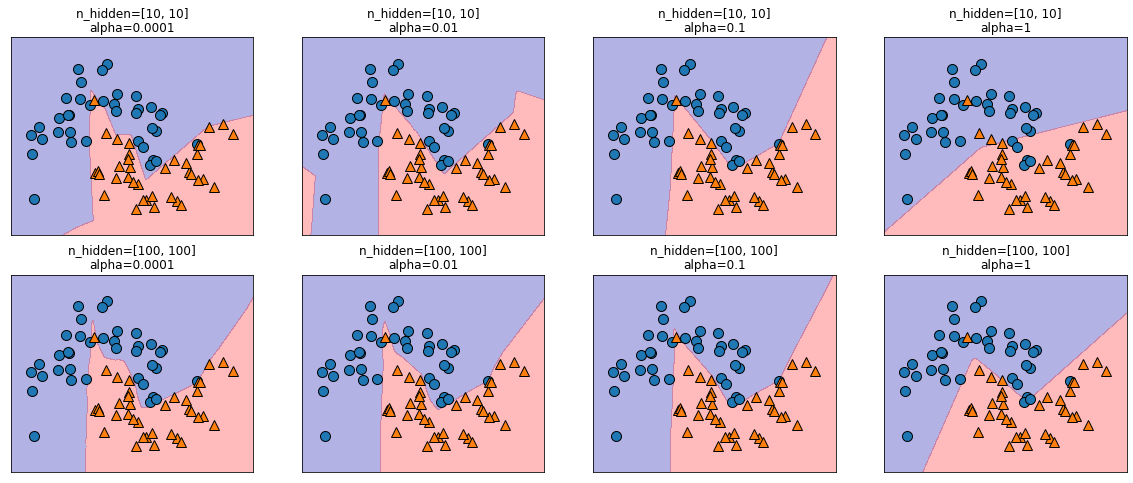

In [49]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

for axx, n_hidden_nodes in zip(axes, [10, 100]):
    for ax, alpha in zip(axx, [0.0001, 0.01, 0.1, 1]):
        
        mlp = MLPClassifier(solver='lbfgs', random_state=0,
        hidden_layer_sizes=[n_hidden_nodes, n_hidden_nodes],
        alpha=alpha,  max_iter = 1000).fit(X_train, y_train)

        mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3, ax=ax)
        mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, ax=ax)
        ax.set_title(f"n_hidden=[{n_hidden_nodes}, {n_hidden_nodes}]\nalpha={alpha}")

Assim como modelos baseados em árvore de decisão, neural networks também utilizam a aleatoriedade no algoritmo. Por isso, mesmo utilizando os mesmos paraâmetros, diferentes modelos podem ser obtidos caso o parâmetro `random_seed` não seja definido. Em datasets grandes com modelos apropriados isso não deve afetar muito os resultados, mas em datasets pequenos sim.
<br>

Vamos aplicar o algoritmo no dataset de câncer de mama, começando com os parâmetros padrão:

In [50]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)

print(f"Accuracy on training set: {mlp.score(X_train, y_train)}")
print(f"Accuracy on test set: {mlp.score(X_test, y_test)}")

Accuracy on training set: 0.9389671361502347
Accuracy on test set: 0.916083916083916


Apesar da acurácia ter sido boa, assim como nos SVMs as redes neurais também são afetadas pelo escalonamento dos dados. Além da escala ser próxima entre as features, idealmente elas teriam que ter a média = 0 e variar de forma similar. Para realizar isso, devemos utilizar o StandardScaler().

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = scaler.fit(cancer.data)
scaler.fit(cancer.data)
scaled_cancer_data = scaler.transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(scaled_cancer_data, cancer.target, random_state=0)

mlp = MLPClassifier(random_state=42, max_iter = 1000)
mlp.fit(X_train, y_train)

print(f"Accuracy on training set: {mlp.score(X_train, y_train)}")
print(f"Accuracy on test set: {mlp.score(X_test, y_test)}")

Accuracy on training set: 0.9882629107981221
Accuracy on test set: 0.965034965034965


O modelo já está tendo uma perfomance boa mas ainda possui um pequeno vão entre a acurácia do training set e do test set. Podemos aumentar a generalização usando o parâmetro de regularização `alpha`. 

In [59]:
mlp = MLPClassifier(random_state=42, max_iter = 1000, alpha = 0.1)
mlp.fit(X_train, y_train)

print(f"Accuracy on training set: {mlp.score(X_train, y_train)}")
print(f"Accuracy on test set: {mlp.score(X_test, y_test)}")

Accuracy on training set: 0.9906103286384976
Accuracy on test set: 0.972027972027972


Entender e analisar o que a rede neural aprendeu é possível, mas geralmente bem mais complexo do que usando um modelo linear simples. Utilizando uma função da documentação do scikit-learn, podemos observar os pesos que foram escolhidos para os inputs que entraram no primeiro hidden layer.
<br>
As linhas do plot correspondem às 30 features do dataset e as colunas correspondem às 100 hidden units. 

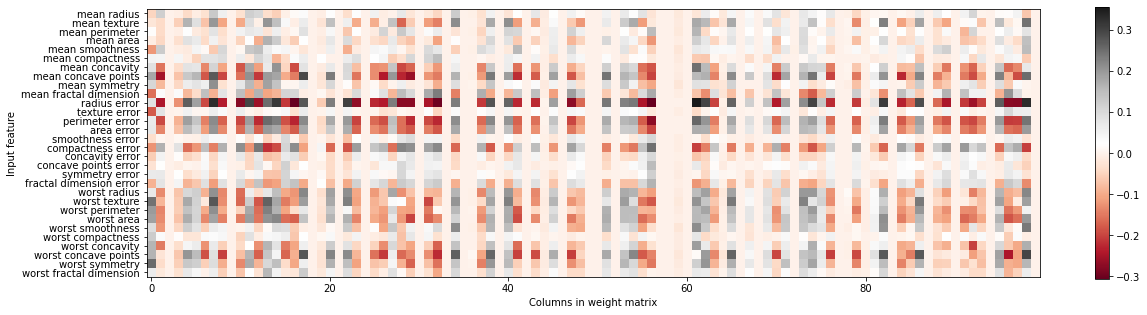

In [67]:
plt.figure(figsize=(20, 5))
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='RdGy')
plt.yticks(range(30), cancer.feature_names)
plt.xlabel("Columns in weight matrix")
plt.ylabel("Input feature")
plt.colorbar()

Uma das possíveis inferências que podem ser feitas com esse plot é que as features com pesos baixos pra quase todas hidden units são menos importantes para o modelo (por exemplo mean smoothness, mean compactness, smoothness error e outras) ou que simplemente não representamos elas de uma forma que a rede neural pudesse utilizar. 
<br>

Apesar de serem mais fáceis de utilizar, as neural networks do scikit-learn mostram uma pequena porcentagem do que dá pra fazer com as neural networks. Bibliotecas como keras, lasagna e tensor-flow suportam maior flexibilidade.    

### Resumo Neural Networks

* As redes neurais voltaram como algoritmos `state-of-the-art` em muitas aplicações de ML. Elas são capazes de capturar informações em quantidades absurdas de dados e constroem modelos extremamente complexos. 
* O ponto negativo é o tempo de treinamento desses modelos, principalmente os mais complexos. Além disso, também precisam de muito cuidado no pré-processamento dos dados e no ajuste de parâmetros.
* Os parâmetros mais importantes são o número de hidden layers e o número de hidden units. Normalmente se começa com 1 ou 2 layers e se expande a partir daí. Já os núemros de units devem ser similares ao número de features. 
* Uma forma comum de ajustar os parâmetros de uma NN é criar uma grande o suficiente para dar overfitting e garantir que aquele tamanho é capaz de aprender todos os dados. Daí dá pra diminuir a rede neural ou aumnetar a regularização usando o parâmetro alpha, melhorando assim a generalização.
* O solver é o parâmetro que define como será feita a otimização. Por padrão é usado o `adam`, que funciona bem na maioria das situações mas é bem sensívelao escalonamento dos dados. Tem também o `lbfgs` que é bem robusto, mas toma bastante tempo em datasets grandes. Além deles, uma escolha comum é o `sgd`, que tem muitos parâmetros adicionais e é o mais usado por pesquisadores de deep learning.

# Estimativa de Incerteza dos Classificadores

Em muitos problemas resolvidos por classificadores, apenas saber a label que o modelo prevê não basta. Em aplicações no mundo real, como em situações médicas, saber o **quão certo o modelo está daquele resultado é ainda mais importante**. 
<br>

No scikit-learn, existem duas funções que podem ser usadas pra obter as estimativas de incerteza: `decision_function` e `predict_proba`. A maioria dos modelos tem pelo menos uma dessas funções e vários tem ambas.  Vamos observar o que as funções retornam usando um modelo de Gradient Boosting:

In [68]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_blobs, make_circles

X, y = make_circles(noise=0.25, factor=0.5, random_state=1)

y_named = np.array(["azul", "vermelho"])[y]

X_train, X_test, y_train_named, y_test_named, y_train, y_test = train_test_split(X, y_named, y, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)

GradientBoostingClassifier(random_state=0)

In [71]:
print(f"X_test.shape: {X_test.shape}")
print(f"Decision function shape: {gbrt.decision_function(X_test).shape}")
print(f"Decision function:\n{gbrt.decision_function(X_test)[:6]}")

X_test.shape: (25, 2)
Decision function shape: (25,)
Decision function:
[ 4.13592603 -1.70169917 -3.95106099 -3.62609552  4.28986642  3.66166081]


A `decision_function` retorna uma array com o número de inputs que foram usados pra teste. O valor significa o quão fortemente o modelo significa que aquele ponto pertence a classe positiva. Valores negativos significam que o modelo classificou aquela input como 0.
<br>

A `predict_proba` retorna a probabilidade pra cada classe e geralmente é bem mais simples de interpretar. Abaixo podemos ver que nesses pontos o modelo teve bastante certeza de cada uma das previsões que fez. 

In [74]:
print(f"Decision probabilities:\n{gbrt.predict_proba(X_test)[:6]}")

Decision probabilities:
[[9.99668724e-01 3.31276217e-04]
 [9.99055975e-01 9.44025298e-04]
 [9.99349757e-01 6.50243045e-04]
 [9.98592306e-01 1.40769403e-03]
 [9.62598787e-01 3.74012129e-02]
 [9.96278683e-01 3.72131671e-03]]


Na documentação do scikit-learn, existe uma função que tem uma baita comparação entre diversos modelos e como as estimativas de incerteza deles se comportam. Foram usados 3 datasets e 10 modelos diferentes:

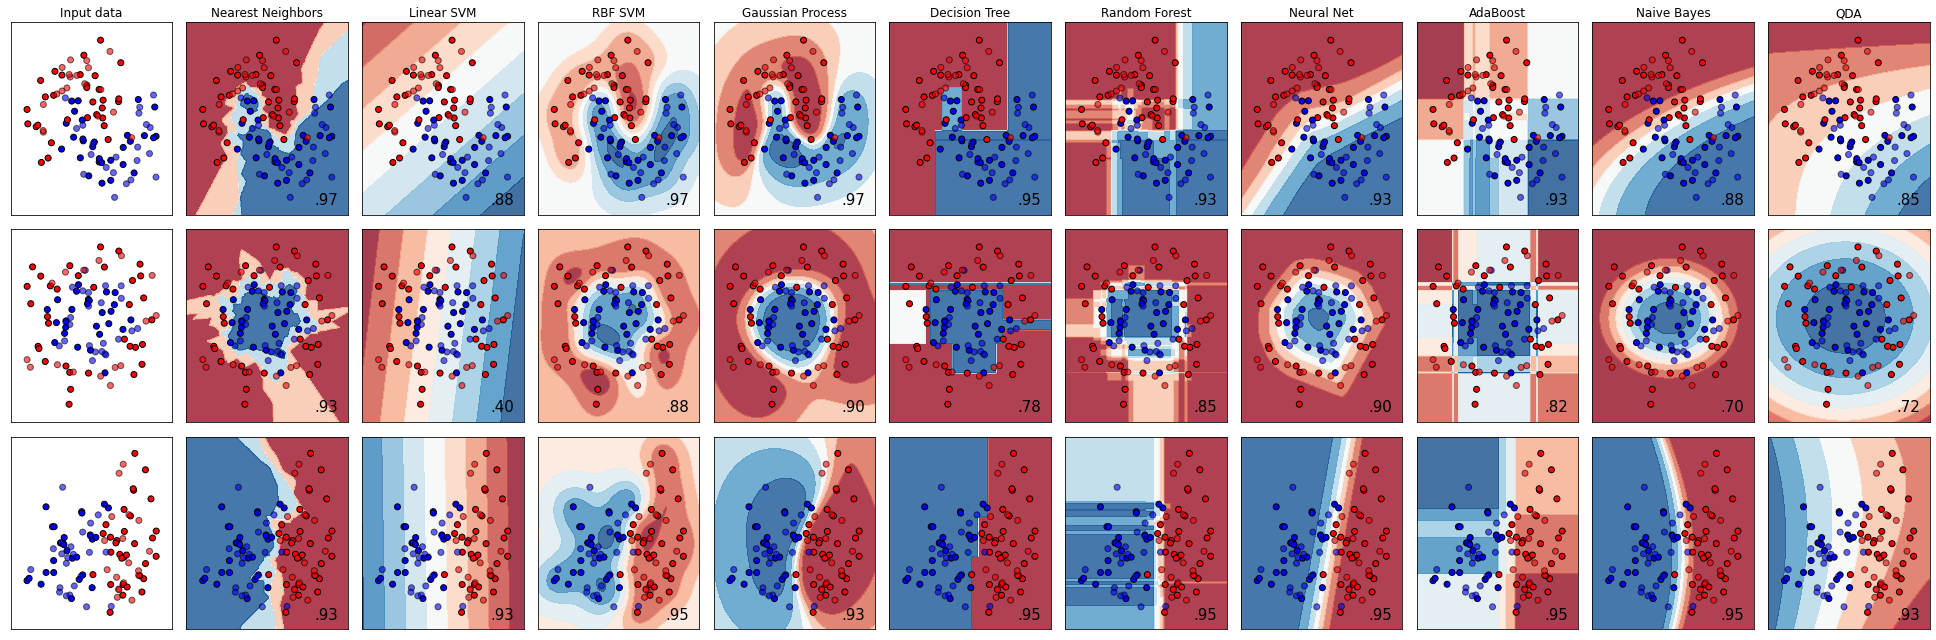

In [73]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

### Incertezas em classificação multiclasse

Para problemas multiclasse, como o dataset das flores que usamos na primeira parte desse capítulo (e no primeiro capítulo também), as funções acima funcionam da mesma forma. Vamos exemplificar:

In [77]:
from sklearn.datasets import load_iris

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=42)

gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, random_state=0)

In [78]:
print(f"X_test.shape: {X_test.shape}")
print(f"Decision function shape: {gbrt.decision_function(X_test).shape}")
print(f"Decision function:\n{gbrt.decision_function(X_test)[:6]}")

X_test.shape: (38, 4)
Decision function shape: (38, 3)
Decision function:
[[-1.995715    0.04758267 -1.92720695]
 [ 0.06146394 -1.90755736 -1.92793758]
 [-1.99058203 -1.87637861  0.09686725]
 [-1.995715    0.04758267 -1.92720695]
 [-1.99730159 -0.13469108 -1.20341483]
 [ 0.06146394 -1.90755736 -1.92793758]]


In [79]:
print(f"Decision probabilities:\n{gbrt.predict_proba(X_test)[:6]}")

Decision probabilities:
[[0.10217718 0.78840034 0.10942248]
 [0.78347147 0.10936745 0.10716108]
 [0.09818072 0.11005864 0.79176065]
 [0.10217718 0.78840034 0.10942248]
 [0.10360005 0.66723901 0.22916094]
 [0.78347147 0.10936745 0.10716108]]


Elas retornam arrays com o número de classificações possíveis (nesse caso, 3). Cada uma das colunas corresponde ao score, no caso da `decision_function`, ou à probabilidade de cada classe.
<br>

Note que a função `decision_function` em classificação binária apenas retorna o score para a classe positiva. 

# Referência

**An Introduction to Machine Learning with Python** by Andreas C. Müller and Sarah Guido (O’Reilly), cap. 2. Copyright 2017 Sarah Guido and Andreas Müller, 978-1-449-36941-5.